In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_val = x_train[-5000:]
x_train = x_train[:-5000]

print("CIFAR-10 shapes:")
print("  x_train:", x_train.shape)
print("  x_val:  ", x_val.shape)
print("  x_test: ", x_test.shape)


def build_sparse_autoencoder(input_shape=(32, 32, 3), latent_dim=32, units_per_layer=256, activation='tanh', learning_rate=0.003, beta=1e-5):

    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation=activation, padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation=activation, padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units_per_layer, activation=activation)(x)

    # Capa latente con regularización L1
    latent = layers.Dense(
        latent_dim, 
        activation=activation,
        activity_regularizer=regularizers.l1(beta)
    )(x)

    # Decoder
    x = layers.Dense(8 * 8 * 64, activation=activation)(latent)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation=activation, padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation=activation, padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Modelo
    model = tf.keras.Model(inputs, outputs, name="best_sparse_conv_ae")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model


betas = [0.1, 0.3]  # Valores de regularización inicial
EPOCHS = 10         # Más épocas para permitir un mejor entrenamiento
BATCH_SIZE = 64

num_samples = 3
indices = np.random.choice(range(x_test.shape[0]), num_samples, replace=False)
sample_images = x_test[indices]

reconstructions_dict = {}
val_mse_dict = {}

for b in betas:
    print(f"\nEntrenando con beta = {b}")
    model = build_sparse_autoencoder(latent_dim=32, beta=b)
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(
        x_train, x_train,
        validation_data=(x_val, x_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    #MSE de validación final
    final_val_mse = history.history['val_loss'][-1]
    val_mse_dict[b] = final_val_mse
    print(f"  -> MSE de validación (última época): {final_val_mse:.6f}")

    # Reconstrucción de las mismas muestras x_test
    reconstructions = model.predict(sample_images)
    reconstructions_dict[b] = reconstructions



CIFAR-10 shapes:
  x_train: (45000, 32, 32, 3)
  x_val:   (5000, 32, 32, 3)
  x_test:  (10000, 32, 32, 3)

Entrenando con beta = 0.1
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 10.1850 - val_loss: 0.7114
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.5280 - val_loss: 0.3327
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2827 - val_loss: 0.2477
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2399 - val_loss: 0.3053
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.1650 - val_loss: 0.1347
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.1156 - val_loss: 0.1109
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0975 - val_loss: 0.0937
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0861 - val_loss: 0.0866
Epoch 9/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0789 - val_loss: 0.0815
Epoch 10/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0761 - val_

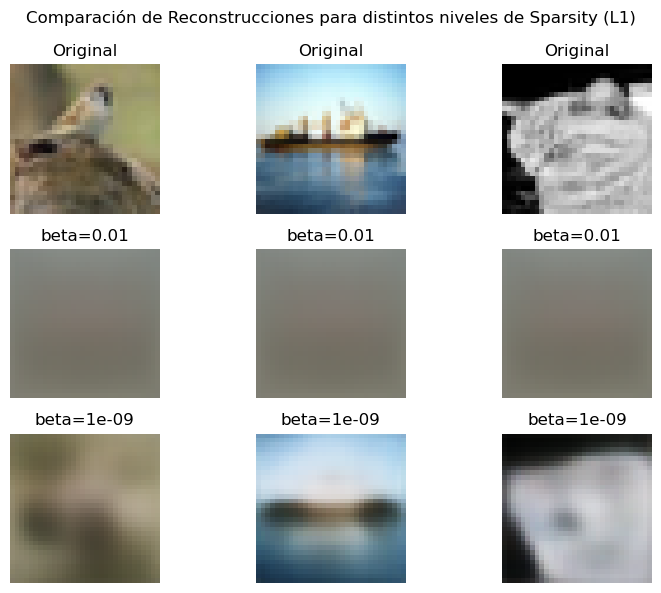


Resumen de MSE de validación por beta:
  beta=0.01: MSE=0.063904
  beta=1e-09: MSE=0.012088

Mejor beta según MSE en validación: 1e-09


In [2]:
plt.figure(figsize=(8, 2 + 2 * len(betas)))

# imágenes originales
for i in range(num_samples):
    ax = plt.subplot(len(betas) + 1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

#reconstrucciones para cada beta
for row, b in enumerate(betas, start=1):
    recon = reconstructions_dict[b]
    for col in range(num_samples):
        ax = plt.subplot(len(betas) + 1, num_samples, row * num_samples + col + 1)
        plt.imshow(recon[col])
        plt.title(f"beta={b}")
        plt.axis("off")

plt.suptitle("Comparación de Reconstrucciones para distintos niveles de Sparsity (L1)")
plt.tight_layout()
plt.show()

print("\nResumen de MSE de validación por beta:")
for b, mse in val_mse_dict.items():
    print(f"  beta={b}: MSE={mse:.6f}")

best_beta = min(val_mse_dict, key=val_mse_dict.get)
print(f"\nMejor beta según MSE en validación: {best_beta}")